In [50]:
!pip install opencv-python
import numpy as np
import cv2
import time 
!pip install -U autopy
import autopy

In [51]:
#moving mouse coordinates
def move_mouse_by_defference(x_new,y_new):
    x0,y0=autopy.mouse.location()
    autopy.mouse.move(x0+x_new,y0+y_new)
move_mouse_by_defference(-30,150)

In [53]:
#Holds down or releases the given mouse button in the current position.
#Button can be LEFT, RIGHT, MIDDLE, or None to default to the left button.
def click_mouse_left():
    autopy.mouse.click(autopy.mouse.Button.LEFT)
click_mouse_left()

In [58]:
def click_mouse_right():
    autopy.mouse.click(button=autopy.mouse.Button.RIGHT)
click_mouse_right()

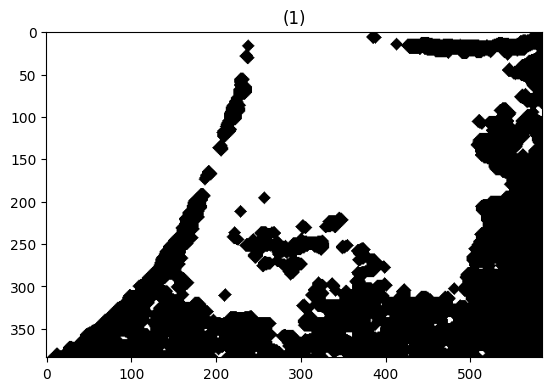

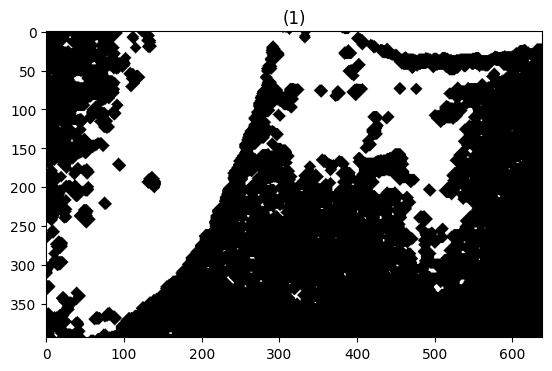

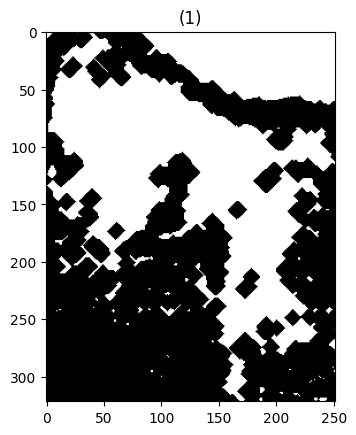

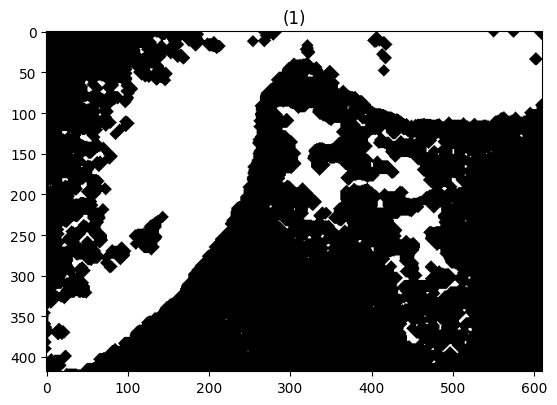

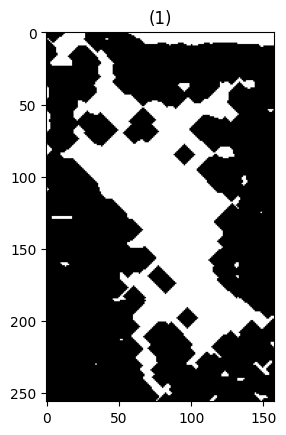

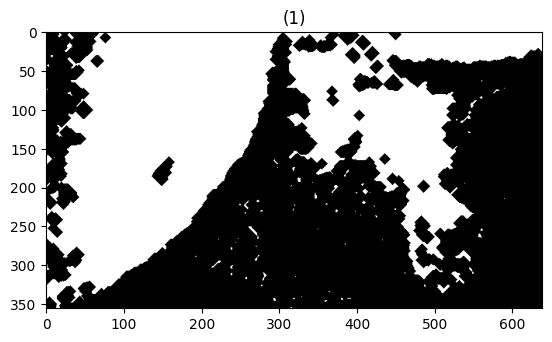

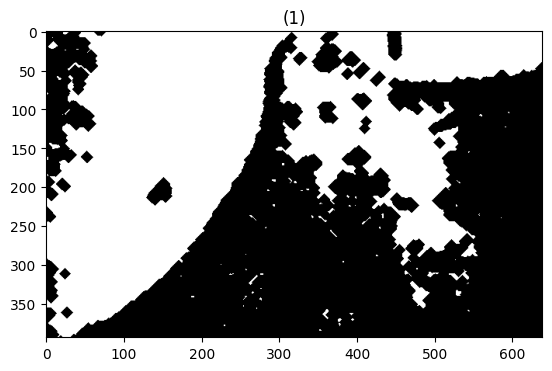

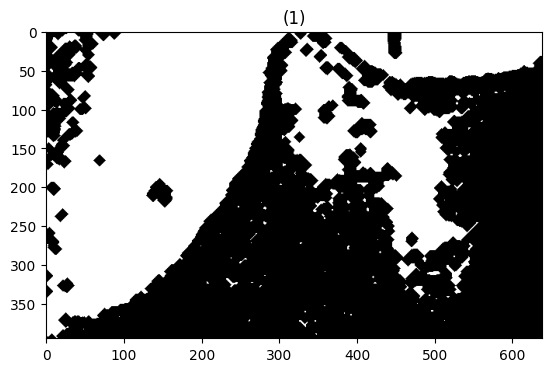

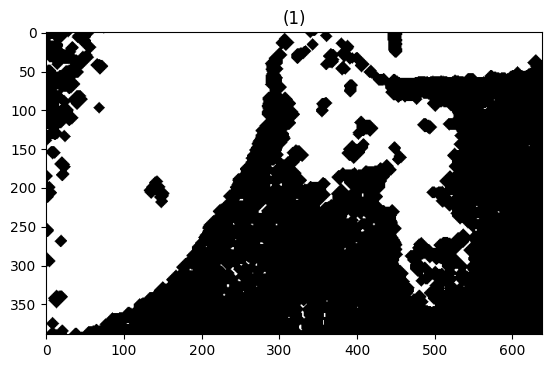

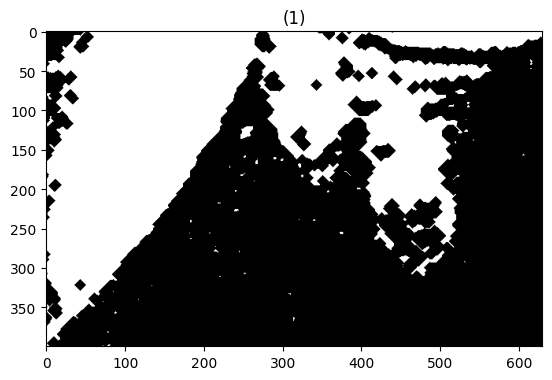

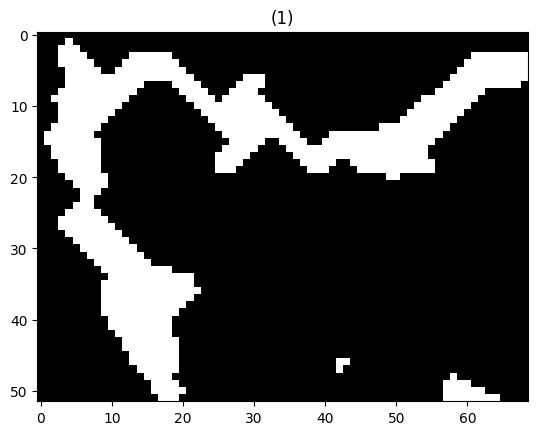

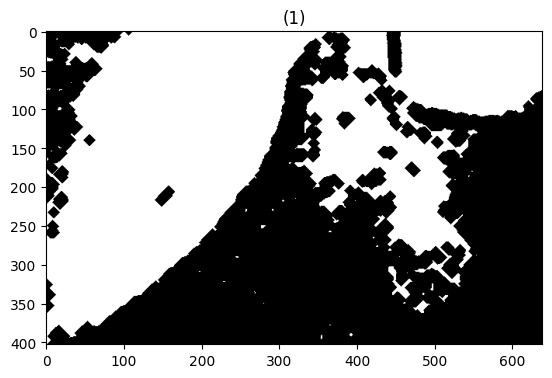

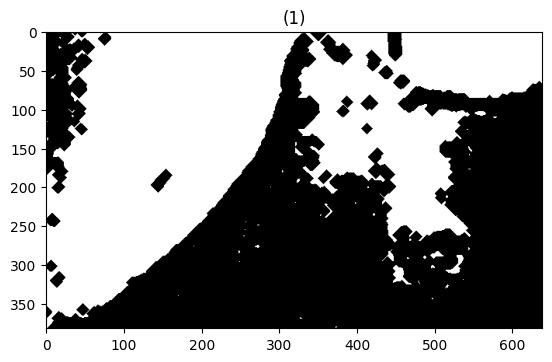

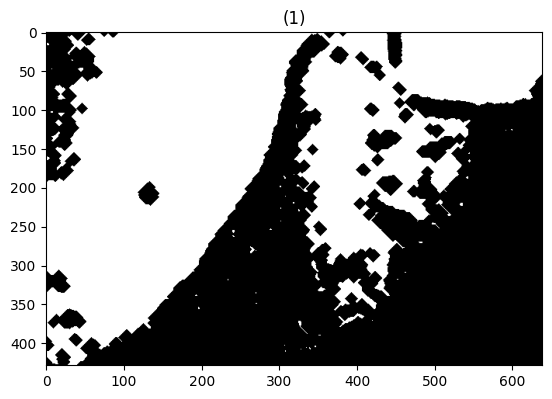

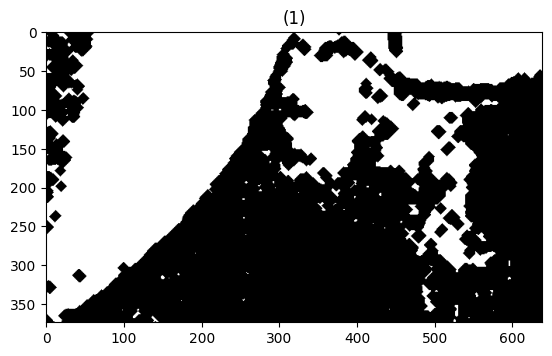

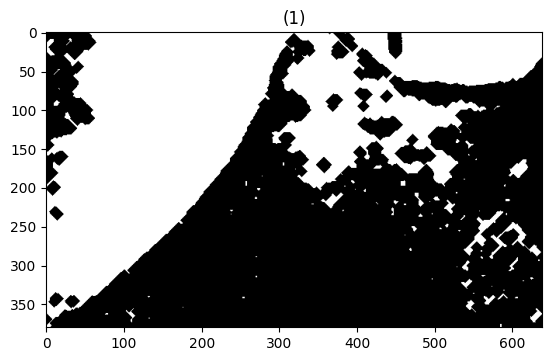

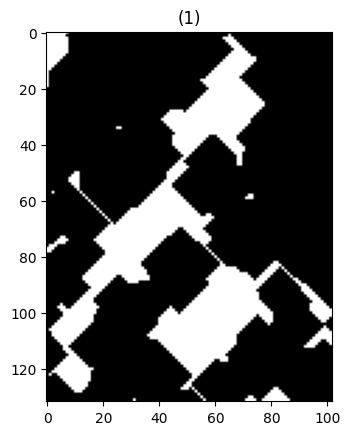

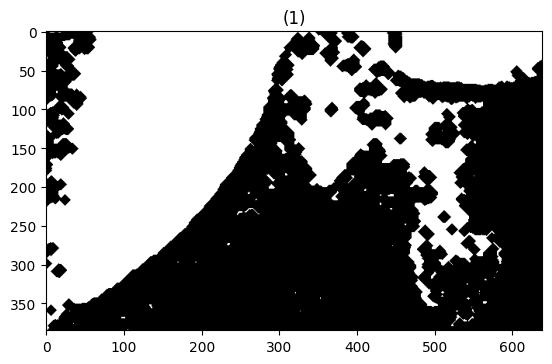

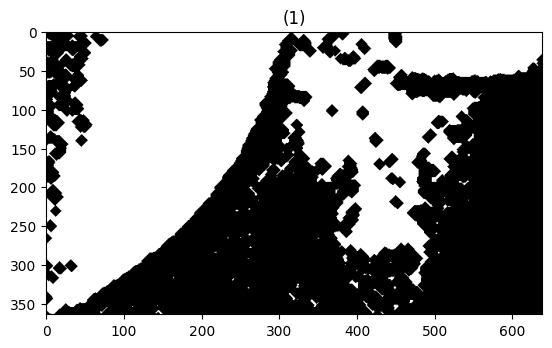

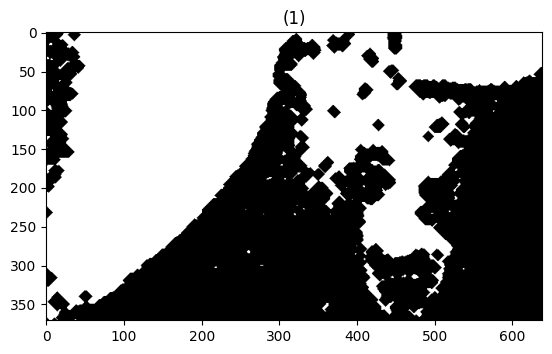

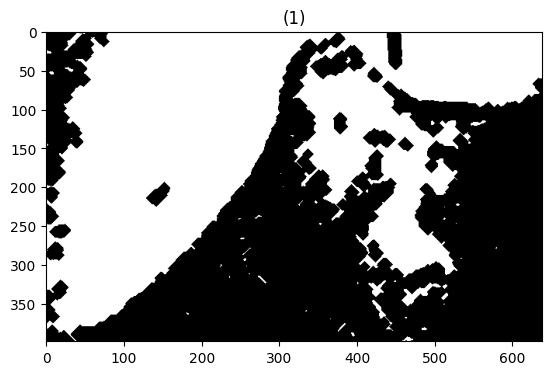

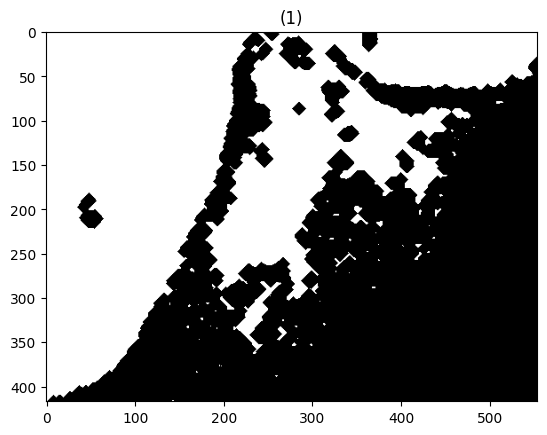

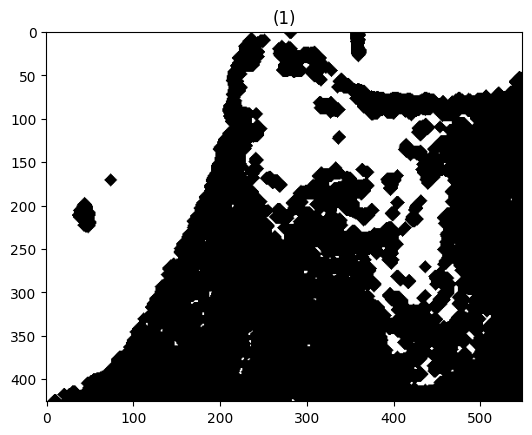

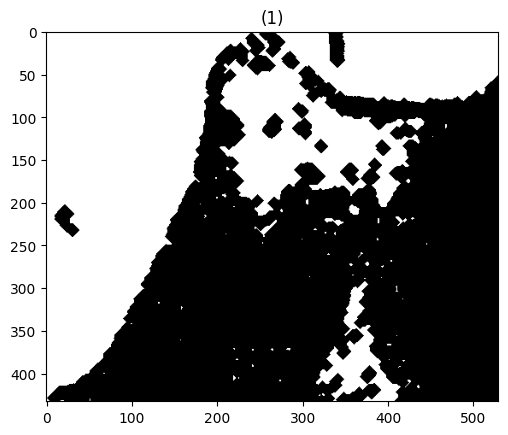

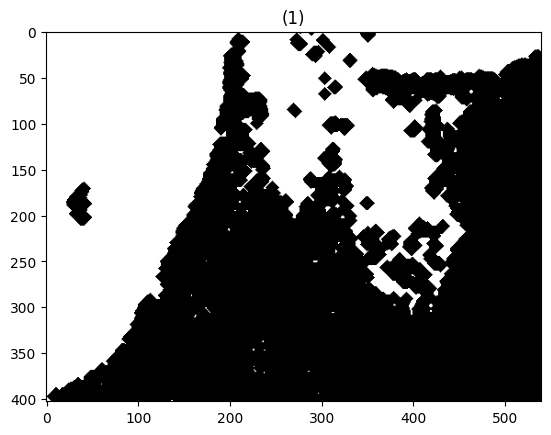

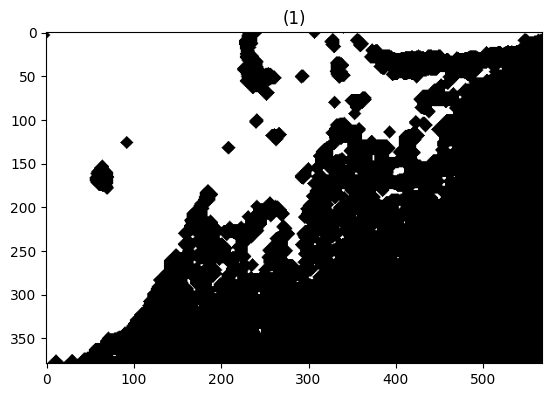

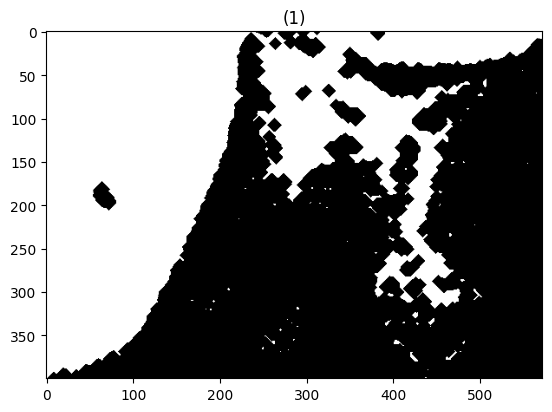

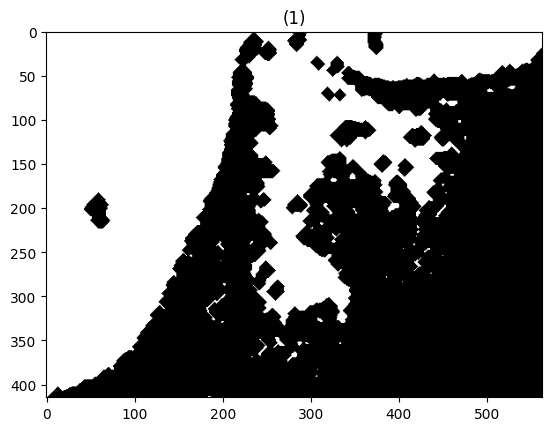

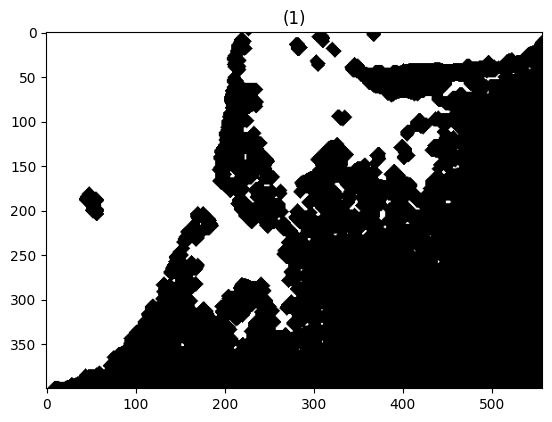

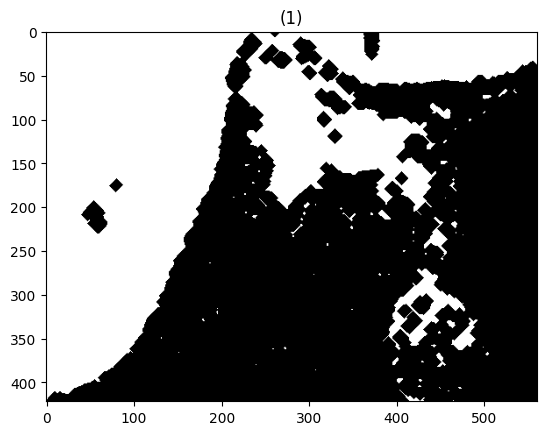

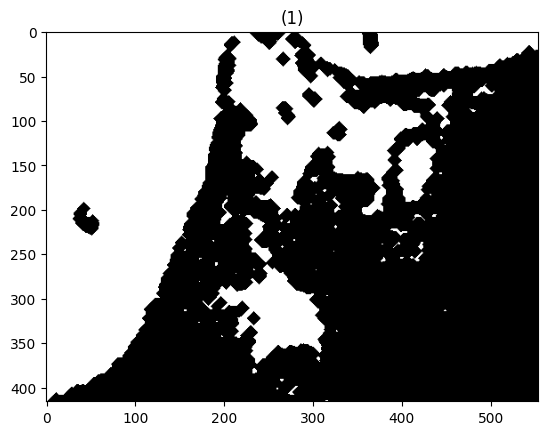

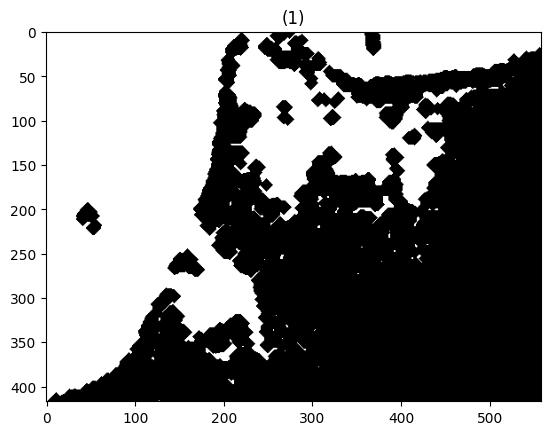

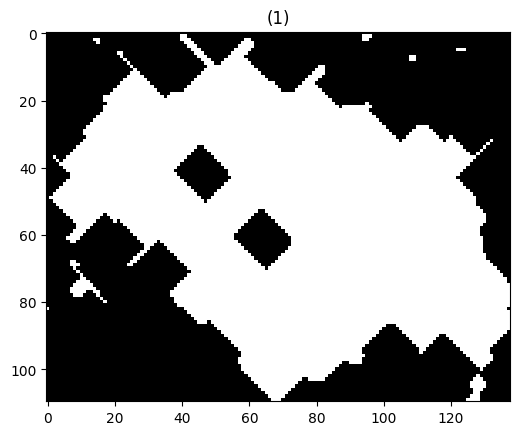

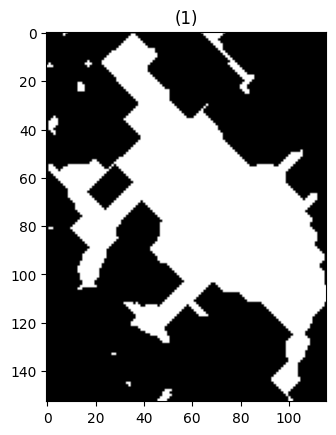

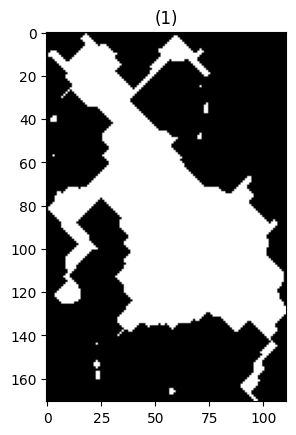

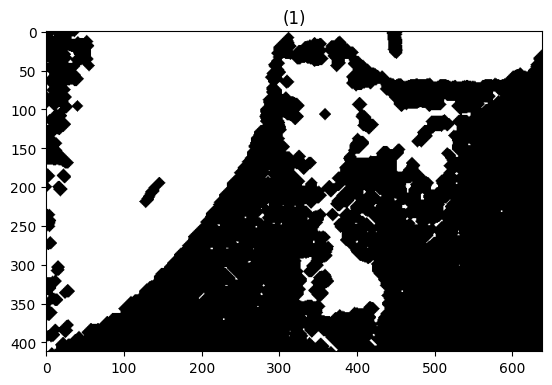

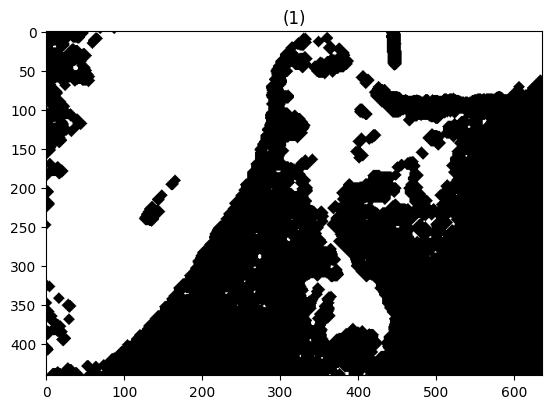

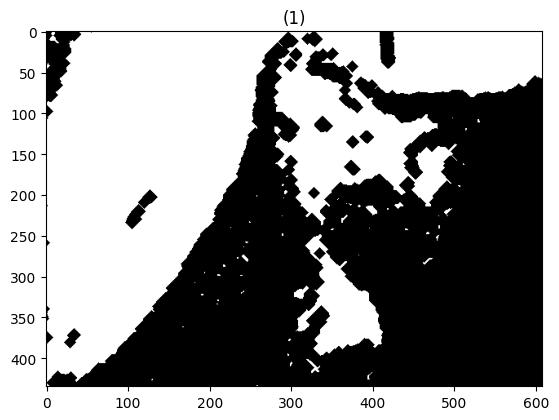

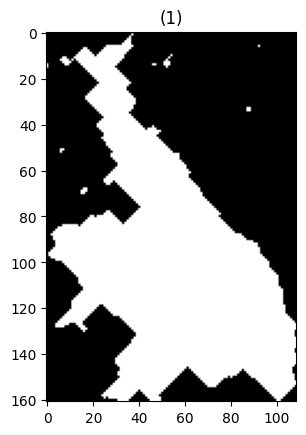

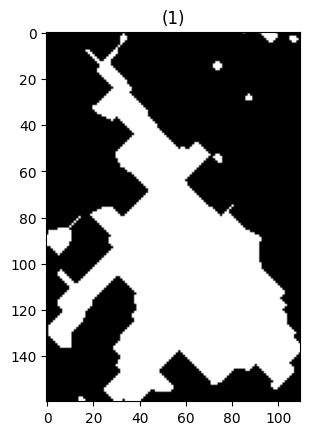

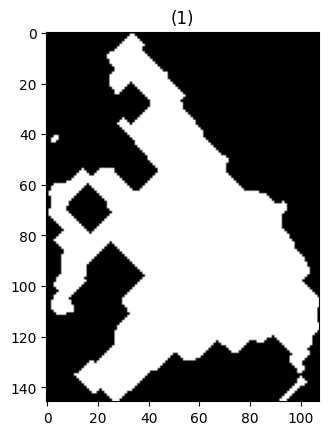

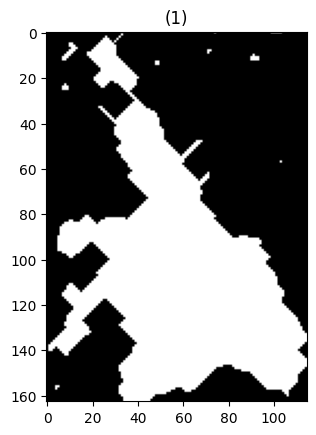

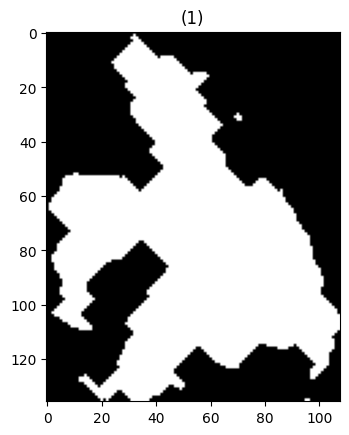

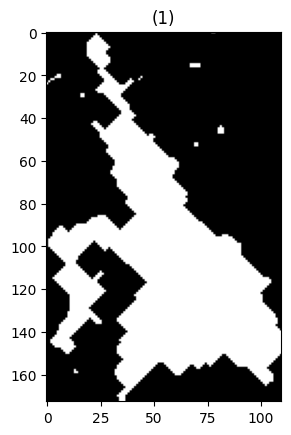

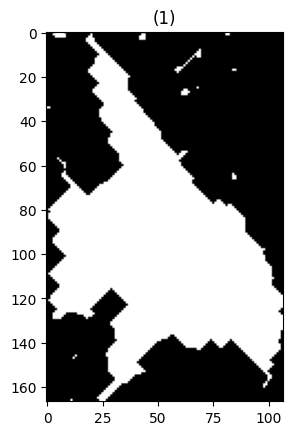

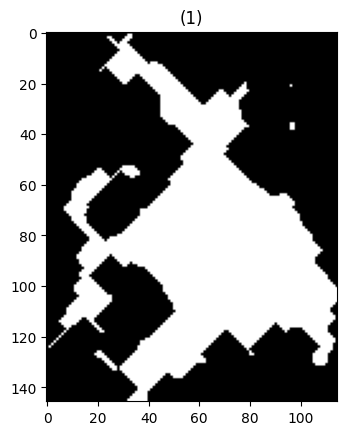

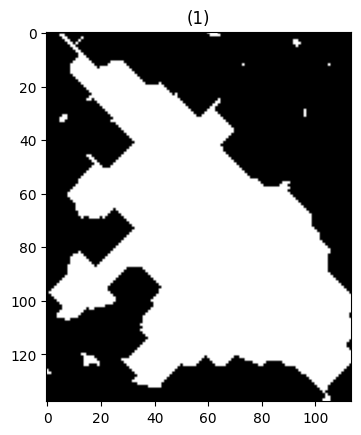

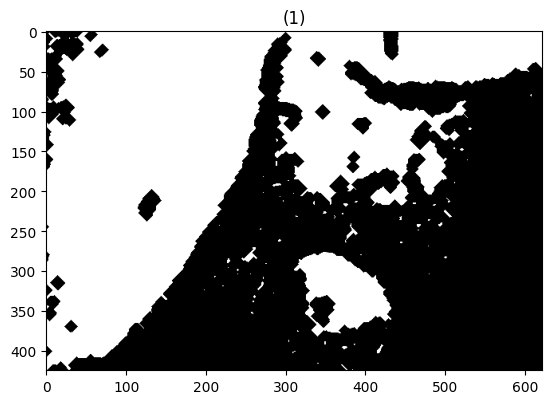

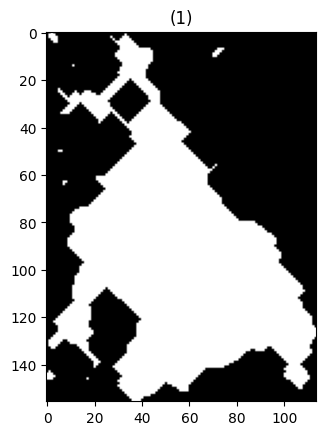

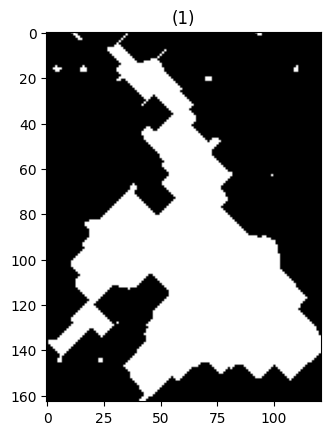

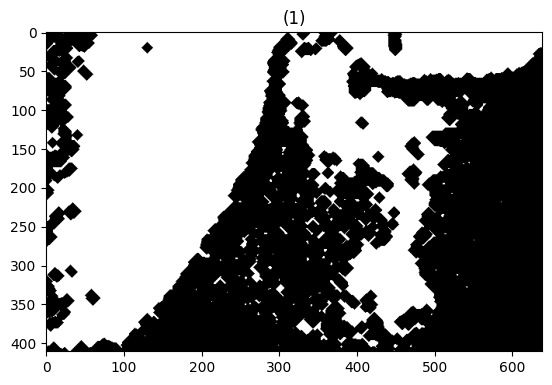

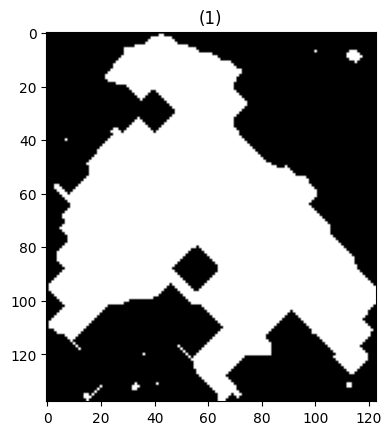

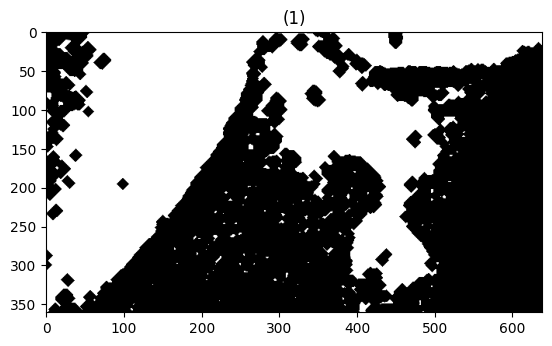

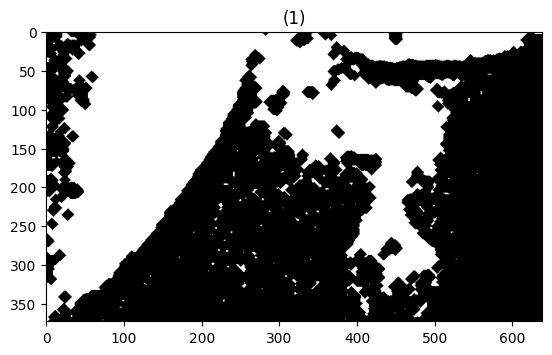

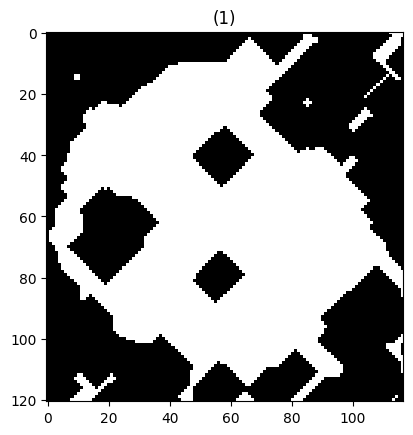

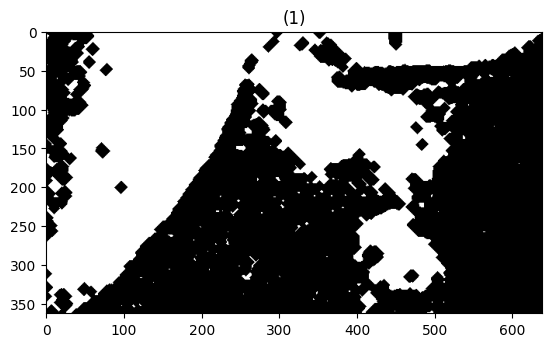

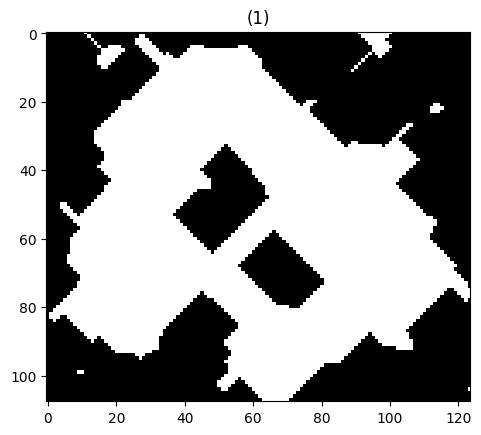

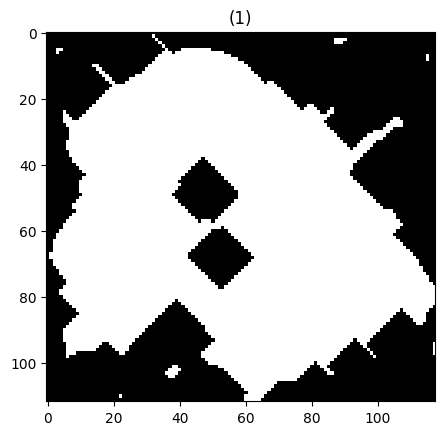

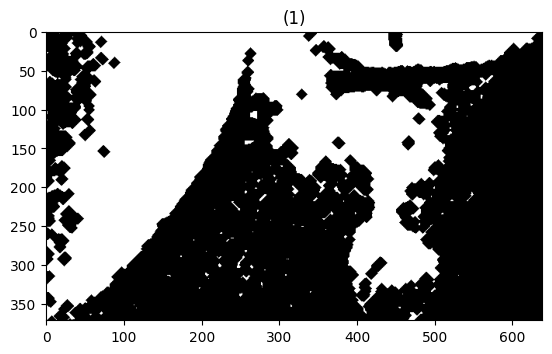

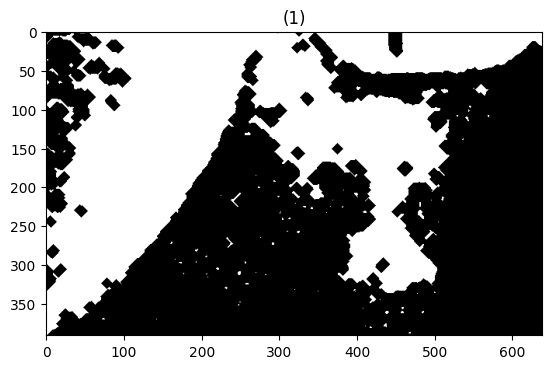

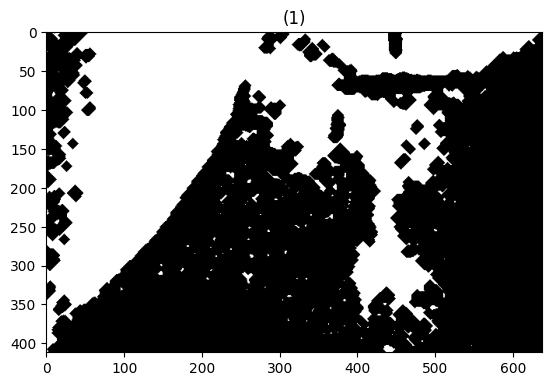

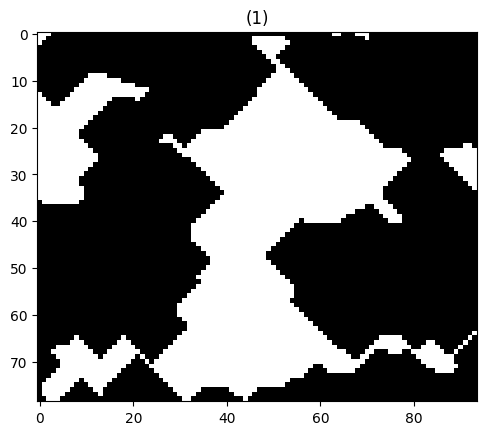

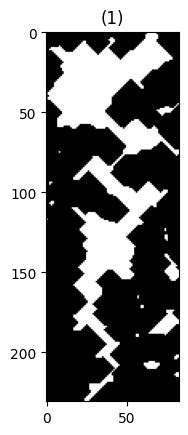

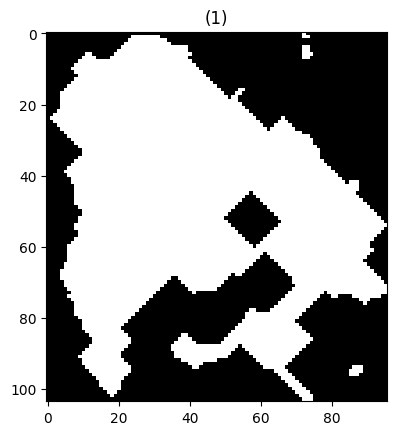

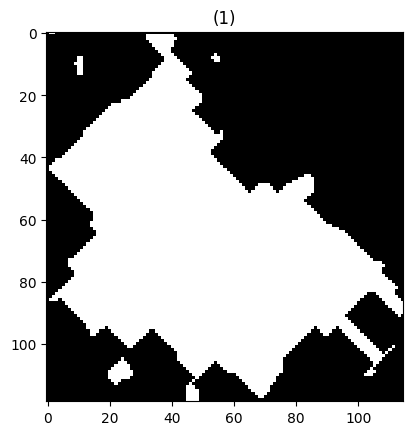

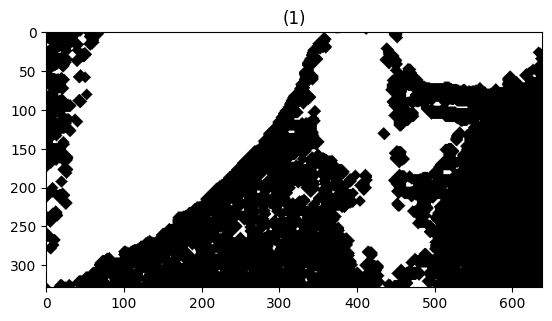

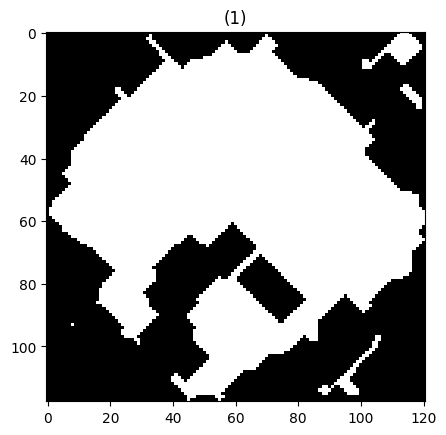

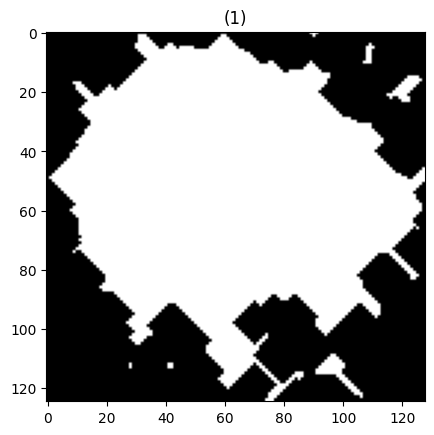

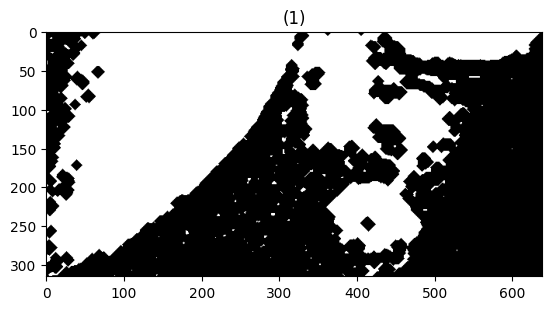

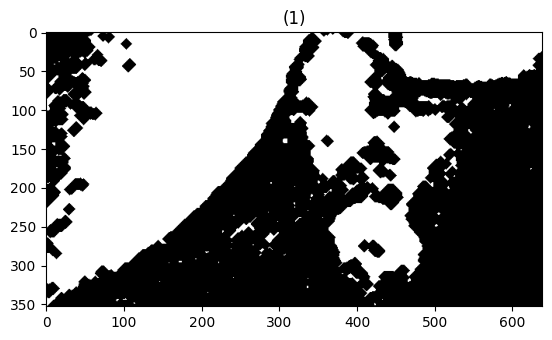

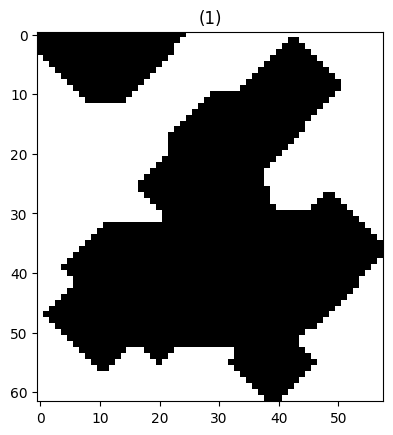

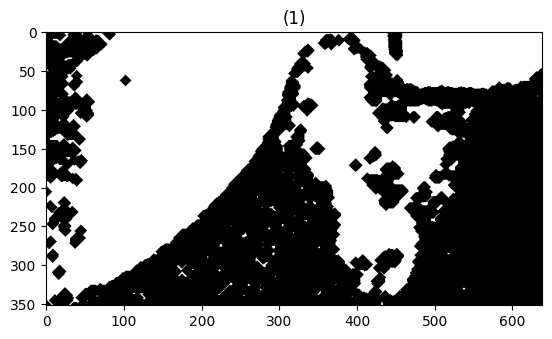

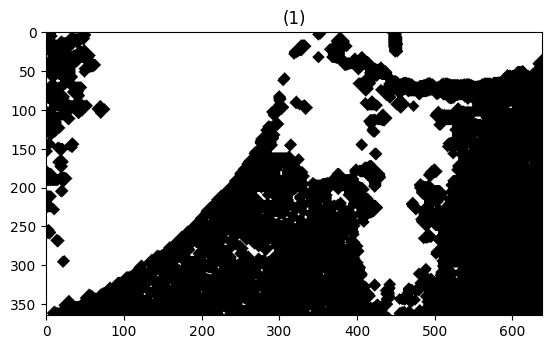

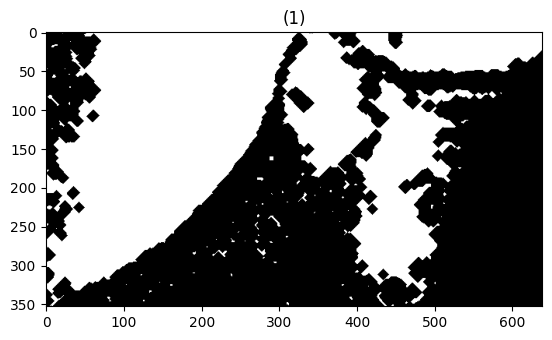

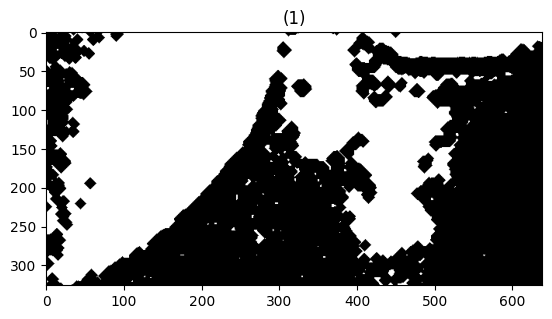

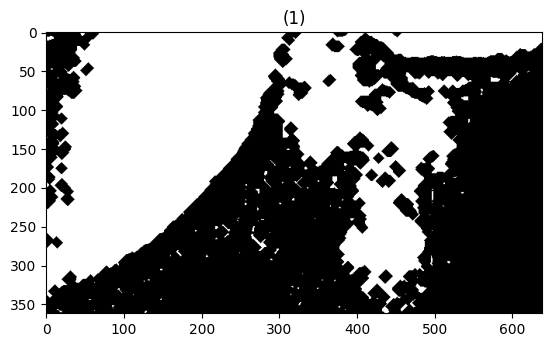

KeyboardInterrupt: 

In [1]:

from commonfunctions import *
import numpy as np
import cv2 as cv
import mediapipe as mp
from time import sleep
from functools import cmp_to_key
import os
import pyautogui as pg



# get threshold value
def calcThreshold(hist, accHist, iFrom, iTo):
    iFrom, iTo = int(iFrom), int(iTo)
    numOfPixels = accHist[iTo] - (accHist[iFrom - 1] if iFrom > 0 else 0)
    mean = np.sum(
        hist[iFrom:iTo+1] * np.arange(iFrom, iTo+1)
    ) / numOfPixels
    return round(mean)


def avgThreshold(hist, accHist, Tinit):
    mean1 = calcThreshold(hist, accHist, 0, Tinit - 1)
    mean2 = calcThreshold(hist, accHist, Tinit, hist.shape[0] - 1)
    newThreshold = round((mean1 + mean2) / 2)
    return newThreshold if Tinit == newThreshold else avgThreshold(hist, accHist, newThreshold)


def getGlobalThreshold(img):
    img2 = np.copy(img)
    hist = np.histogram(img2, bins=np.arange(256))[0]
    accHist = np.cumsum(hist)
    Tinit = calcThreshold(hist, accHist, 0, hist.shape[0] - 1)
    return avgThreshold(hist, accHist, Tinit)  # get threshold


def get_image_with_skin_color(img):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = (B - Y) * 0.564 + 128
    Cr = (R - Y) * 0.713 + 128
    outImg = (Cb >= 77) * (Cb <= 127) * (Cr >= 133) * (Cr <= 187)
    return outImg


def get_image_with_skin_color_hsv(img):
    lower_hsv = np.array([0, 48, 80], dtype="uint8")
    upper_hsv = np.array([20, 255, 255], dtype="uint8")
    hsv_image = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    skin_region = cv.inRange(hsv_image, lower_hsv, upper_hsv)
    return skin_region


def enhance_image(img):
    se = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]).astype('uint8')
    enhanced_image = np.array(img).astype('uint8')
    enhanced_image = cv.dilate(
        enhanced_image, se, iterations=7
    )
    enhanced_image = cv.erode(
        enhanced_image, se, iterations=7
    )
    return enhanced_image


def compare(item1, item2):
    return item2[0] - item1[0]


def detectHand(binaryImg, mainImg):
    contours = find_contours(binaryImg,  fully_connected='high')
    contours = [
        [
            int(np.min(contour[:, 0])), int(np.max(contour[:, 0])),
            int(np.min(contour[:, 1])), int(np.max(contour[:, 1]))
        ]
        for contour in contours]
    contours = sorted(contours, key=cmp_to_key(compare))
    for contour in contours:
        [Xmin, Xmax, Ymin, Ymax] = contour
        if Xmax - Xmin >= 50 and Ymax - Ymin >= 50:
            temp_image = mainImg[max(Xmin-70, 0):min(Xmax+70, mainImg.shape[0]),
                                max(Ymin-70, 0):min(Ymax+70, mainImg.shape[1])]
            mp_hands = mp.solutions.hands
            hand = mp_hands.Hands()
            result = hand.process(temp_image)
            if result.multi_hand_landmarks:
                return np.array(binaryImg[Xmin:Xmax, Ymin:Ymax]), (Xmin, Xmax, Ymin, Ymax)
    return None, (0, 0)


def captureImage(cap):
    success, img = cap.read()
    img = cv.flip(img, 1)
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    if cv.waitKey(1) & 0xff == ord('q'):
        cv.destroyAllWindows()
        cap.release()
        exit(0)
    return imgRGB


def compareFingers(contour1, contour2):
    return int(np.max(contour1[:, 0])-np.min(contour1[:, 0])) - int(np.max(contour2[:, 0])-np.min(contour2[:, 0]))


def detectFingers(original):
    if original is None:
        return None, None
    image = original > 0.9
    numberOfIteration = (image.shape[0]+image.shape[1])//12
    for i in range(numberOfIteration):
        image = binary_erosion(image)
    for i in range(numberOfIteration):
        image = binary_dilation(image)

    contours = find_contours(image)
    center = ()
    radius = 0

    contours = sorted(contours, key=cmp_to_key(compareFingers))
    if not len(contours) > 0:
        return None, None
    Ymin = int(np.min(contours[-1][:, 1]))
    Ymax = int(np.max(contours[-1][:, 1]))
    Xmin = int(np.min(contours[-1][:, 0]))
    Xmax = int(np.max(contours[-1][:, 0]))
    center = ((Xmin+Xmax)//2, (Ymin+Ymax)//2)
    radius = center[0] - Xmin

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if math.dist((i, j), center) < radius:
                original[i, j] = 0

    for i in range(5):
        original = binary_erosion(original)
    for i in range(5):
        original = binary_dilation(original)
    fingersCotours = find_contours(original)
    fingersCotours = sorted(fingersCotours, key=cmp_to_key(compareFingers))
    if len(fingersCotours) == 0:
        return None, None
    contour = fingersCotours[-1]
    Ymin = int(np.min(contour[:, 1]))
    Ymax = int(np.max(contour[:, 1]))
    Xmin = int(np.min(contour[:, 0]))
    Xmax = int(np.max(contour[:, 0]))
    img = np.copy(original)
    img[Xmin:Xmax, Ymin:Ymax] = 0
    img = original.astype(int) - img.astype(int)

    return (Xmax - Xmin), (Xmax, (Ymin+Ymax)//2)


def get_info_from_fingers(fingers_info):
    length = len(fingers_info)
    if length == 0:
        return None
    if length == 1:
        return fingers_info[0]


# moving mouse coordinates
def move_mouse_by_difference(x_new, y_new):
    x0, y0 = pg.position()
    pg.moveTo(x0 - y_new, y0 - x_new)


def click_the_mouse():
    pg.click()


def isMovingBy(pos1, pos2):
    return pos1[0] - pos2[0], pos1[1] - pos2[1]


def main():
    #
    cap = cv.VideoCapture(0)
    cap.set(cv.CAP_PROP_BUFFERSIZE, 2)
    lastPosition = (0, 0)
    lastLength = 0
    while True:
        img = captureImage(cap)
        sleep(0.5)
        binary_image = get_image_with_skin_color(img)
        binary_image = enhance_image(binary_image)
        hand_image, hand_margin = detectHand(binary_image, img)

        if hand_image is not None:
            show_images([hand_image])

        length, finger_center = detectFingers(hand_image)
        if finger_center is None:
            continue
        finger_center_in_image = (
            finger_center[0]+hand_margin[0], finger_center[1]+hand_margin[2]
        )
        x_change, y_change = isMovingBy(
            lastPosition, finger_center_in_image
        )

        if(lastPosition == (0, 0)):
            lastPosition = finger_center_in_image
        isRisingHand = length >= hand_image.shape[0] // 3
        if (x_change >= 3 or y_change >= 3) and isRisingHand:
            move_mouse_by_difference(x_change, y_change)
        elif lastLength - length >= 30:
            click_the_mouse()

        lastLength = length
        lastPosition = finger_center_in_image


if __name__ == "__main__":
    main()
